# VAR VARMA VARMAX Model for Cruid Oil Forcasting

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn import metrics
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

In [39]:
# Load Data set
data = pd.read_csv('Dow Jones Industrial Average Historical Data.csv', parse_dates= True)
data

,Date,Price,Open,High,Low,Vol.,Change %
0,"Dec 31, 2019","28,538.44","28,414.64","28,547.35","28,376.49",193.34M,0.27%
1,"Dec 30, 2019","28,462.14","28,654.76","28,664.69","28,428.98",185.07M,-0.64%
2,"Dec 27, 2019","28,645.26","28,675.34","28,701.66","28,608.98",184.93M,0.08%
3,"Dec 26, 2019","28,621.39","28,539.46","28,624.10","28,535.15",155.97M,0.37%
4,"Dec 24, 2019","28,515.45","28,572.57","28,576.80","28,503.21",95.29M,-0.13%
...,...,...,...,...,...,...,...
2761,"Jan 09, 2009","8,599.18","8,738.80","8,800.45","8,541.75",-,-1.64%
2762,"Jan 08, 2009","8,742.46","8,769.94","8,807.14","8,593.52",-,-0.31%
2763,"Jan 07, 2009","8,769.70","8,996.94","8,996.94","8,690.45",-,-2.72%
2764,"Jan 06, 2009","9,015.10","8,954.57","9,175.19","8,868.07",-,0.69%


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2766 entries, 0 to 2765
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2766 non-null   object
 1   Price     2766 non-null   object
 2   Open      2766 non-null   object
 3   High      2766 non-null   object
 4   Low       2766 non-null   object
 5   Vol.      2766 non-null   object
 6   Change %  2766 non-null   object
dtypes: object(7)
memory usage: 151.4+ KB


In [41]:
#Convert date in datetime and others in float
#Convert , separted data into numeric
data['Date']= pd.to_datetime(data['Date'])
#data['Price']= pd.to_numeric(data['Price'])
data['Price'] = data['Price'].str.replace(',', '').astype(float)
data['Open'] = data['Open'].str.replace(',', '').astype(float)
data['High']= pd.to_numeric(data['High'].str.replace(',', '').astype(float))
data['Low']= pd.to_numeric(data['Low'].str.replace(',', '').astype(float))
#data['Vol.']= pd.to_numeric(data['Vol.'].str.replace('-', '').astype(string)
#data['Vol.']=data['Vol.'].replace('-', 0)
#data['Vol.']= pd.to_numeric(data['Vol.'].str.replace('M', '').astype(float))
#data['Change %']= pd.to_numeric(data['Change %'].str.replace('%', '').astype(float)) 
data

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-12-31,28538.44,28414.64,28547.35,28376.49,193.34M,0.27%
1,2019-12-30,28462.14,28654.76,28664.69,28428.98,185.07M,-0.64%
2,2019-12-27,28645.26,28675.34,28701.66,28608.98,184.93M,0.08%
3,2019-12-26,28621.39,28539.46,28624.10,28535.15,155.97M,0.37%
4,2019-12-24,28515.45,28572.57,28576.80,28503.21,95.29M,-0.13%
...,...,...,...,...,...,...,...
2761,2009-01-09,8599.18,8738.80,8800.45,8541.75,-,-1.64%
2762,2009-01-08,8742.46,8769.94,8807.14,8593.52,-,-0.31%
2763,2009-01-07,8769.70,8996.94,8996.94,8690.45,-,-2.72%
2764,2009-01-06,9015.10,8954.57,9175.19,8868.07,-,0.69%


In [42]:
#Extract date from 2019-01-14 to 2020-01-30
data = data[(data['Date'] > '2019-01-14') & (data['Date'] <= '2020-01-30')]

In [44]:
df=data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 0 to 242
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      243 non-null    datetime64[ns]
 1   Price     243 non-null    float64       
 2   Open      243 non-null    float64       
 3   High      243 non-null    float64       
 4   Low       243 non-null    float64       
 5   Vol.      243 non-null    object        
 6   Change %  243 non-null    object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 15.2+ KB


In [46]:
#Write function to get Errors
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [45]:
#Write differencing function to make stationary using Dickey-Fuller test-adfuller
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [47]:
df.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

In [48]:
#Apply Dickey-Fuller test-adfuller on only three coloumns
for name, column in df[['Open', 'High', 'Low']].iteritems():
    Augmented_Dickey_Fuller_Test_func(df[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Open
Test Statistic                  -0.886592
p-value                          0.792356
No Lags Used                     0.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: High
Test Statistic                  -1.008774
p-value                          0.750051
No Lags Used                     0.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: Low
Test Statistic                  -1.199365
p-value                          0.673869
No L

In [49]:
#Train Test Split
X = df[['Open', 'High', 'Low']]
train, test = X[0:-30], X[-30:]

In [50]:
#Find Differencing using diff function
train_diff = train.diff()
train_diff.dropna(inplace = True)

In [51]:
#Apply adfuller test
for name, column in train_diff[['Open', 'High', 'Low']].iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Open
Test Statistic                -1.361652e+01
p-value                        1.830638e-25
No Lags Used                   0.000000e+00
Number of Observations Used    2.110000e+02
Critical Value (1%)           -3.461727e+00
Critical Value (5%)           -2.875337e+00
Critical Value (10%)          -2.574124e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: High
Test Statistic                -1.379112e+01
p-value                        8.922269e-26
No Lags Used                   0.000000e+00
Number of Observations Used    2.110000e+02
Critical Value (1%)           -3.461727e+00
Critical Value (5%)           -2.875337e+00
Critical Value (10%)          -2.574124e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Low
Test Statistic                -1.350952e+01
p-value                        2.871409e

In [52]:
#Use coint_johanset
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df): 
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [53]:
cointegration_test(train_diff[['Open', 'High', 'Low']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Open   >  181.12    > 24.2761   =>   True
High   >  96.96     > 12.3212   =>   True
Low    >  30.11     > 4.1296    =>   True


In [54]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_res[str(col)+'_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [56]:
#Use Parameter grid
from sklearn.model_selection import ParameterGrid
param_grid = {'p': [1,2,3], 'q':[1,2,3], 'tr': ['n','c','t','ct']}
pg = list(ParameterGrid(param_grid))
pg

[{'p': 1, 'q': 1, 'tr': 'n'},
 {'p': 1, 'q': 1, 'tr': 'c'},
 {'p': 1, 'q': 1, 'tr': 't'},
 {'p': 1, 'q': 1, 'tr': 'ct'},
 {'p': 1, 'q': 2, 'tr': 'n'},
 {'p': 1, 'q': 2, 'tr': 'c'},
 {'p': 1, 'q': 2, 'tr': 't'},
 {'p': 1, 'q': 2, 'tr': 'ct'},
 {'p': 1, 'q': 3, 'tr': 'n'},
 {'p': 1, 'q': 3, 'tr': 'c'},
 {'p': 1, 'q': 3, 'tr': 't'},
 {'p': 1, 'q': 3, 'tr': 'ct'},
 {'p': 2, 'q': 1, 'tr': 'n'},
 {'p': 2, 'q': 1, 'tr': 'c'},
 {'p': 2, 'q': 1, 'tr': 't'},
 {'p': 2, 'q': 1, 'tr': 'ct'},
 {'p': 2, 'q': 2, 'tr': 'n'},
 {'p': 2, 'q': 2, 'tr': 'c'},
 {'p': 2, 'q': 2, 'tr': 't'},
 {'p': 2, 'q': 2, 'tr': 'ct'},
 {'p': 2, 'q': 3, 'tr': 'n'},
 {'p': 2, 'q': 3, 'tr': 'c'},
 {'p': 2, 'q': 3, 'tr': 't'},
 {'p': 2, 'q': 3, 'tr': 'ct'},
 {'p': 3, 'q': 1, 'tr': 'n'},
 {'p': 3, 'q': 1, 'tr': 'c'},
 {'p': 3, 'q': 1, 'tr': 't'},
 {'p': 3, 'q': 1, 'tr': 'ct'},
 {'p': 3, 'q': 2, 'tr': 'n'},
 {'p': 3, 'q': 2, 'tr': 'c'},
 {'p': 3, 'q': 2, 'tr': 't'},
 {'p': 3, 'q': 2, 'tr': 'ct'},
 {'p': 3, 'q': 3, 'tr': 'n'},
 {

In [57]:
#Find best parameters
df_results_moni = pd.DataFrame(columns=['p', 'q', 'tr','RMSE open','RMSE high','RMSE low'])
print('starting grid search')
start = timer()
for a,b in enumerate(pg):
    p = b.get('p')
    q = b.get('q')
    tr = b.get('tr')
    model = VARMAX(train_diff, order=(p,q), trend=tr).fit()
    z = model.forecast(y=train_diff[['Open', 'High', 'Low']].values, steps=30)
    df_pred = pd.DataFrame(z, columns=[ 'Open', 'High', 'Low'])
    res = inverse_diff(df[['Open', 'High', 'Low']],df_pred)
    openrmse = np.sqrt(metrics.mean_squared_error(test.Open, res.Open_1st_inv_diff))
    highrmse = np.sqrt(metrics.mean_squared_error(test.High, res.High_1st_inv_diff))
    lowrmse = np.sqrt(metrics.mean_squared_error(test.Low, res.Low_1st_inv_diff))
    #closermse = np.sqrt(metrics.mean_squared_error(test.Close, res.Close_1st_inv_diff))
    df_results_moni = df_results_moni.append({'p': p, 'q': q, 'tr': tr,'RMSE open': openrmse,'RMSE high':highrmse,'RMSE low':lowrmse}, ignore_index=True)
end = timer()
print(f' Total time taken to complete grid search in seconds: {(end - start)}')

starting grid search
 Total time taken to complete grid search in seconds: 594.7676257


In [62]:
df_results_moni.head()

,p,q,tr,RMSE open,RMSE high,RMSE low
0,1,1,n,1358.303522,1262.311253,1343.709741
1,1,1,c,1587.372281,1491.652824,1551.527299
2,1,1,t,1458.978522,1374.891775,1421.839974
3,1,1,ct,1254.182293,1188.655397,1233.536415
4,1,2,n,1283.241829,1186.368983,1258.114912


In [61]:
df_results_moni.sort_values(by = ['RMSE open','RMSE high','RMSE low'] )

,p,q,tr,RMSE open,RMSE high,RMSE low
27,3,1,ct,1195.852885,1134.453585,1191.863768
31,3,2,ct,1246.573280,1171.449621,1225.231292
11,1,3,ct,1249.840677,1170.250380,1215.826992
35,3,3,ct,1252.239838,1170.158339,1232.496083
19,2,2,ct,1253.233022,1171.967321,1225.502664
3,1,1,ct,1254.182293,1188.655397,1233.536415
16,2,2,n,1260.801422,1168.550368,1234.483304
8,1,3,n,1272.046717,1177.160817,1240.318355
23,2,3,ct,1279.781513,1199.767806,1245.630650
15,2,1,ct,1280.849764,1213.852428,1254.885334


In [63]:
df_results_moni.sort_values(by = ['RMSE open','RMSE high','RMSE low'] )

,p,q,tr,RMSE open,RMSE high,RMSE low
27,3,1,ct,1195.852885,1134.453585,1191.863768
31,3,2,ct,1246.573280,1171.449621,1225.231292
11,1,3,ct,1249.840677,1170.250380,1215.826992
35,3,3,ct,1252.239838,1170.158339,1232.496083
19,2,2,ct,1253.233022,1171.967321,1225.502664
3,1,1,ct,1254.182293,1188.655397,1233.536415
16,2,2,n,1260.801422,1168.550368,1234.483304
8,1,3,n,1272.046717,1177.160817,1240.318355
23,2,3,ct,1279.781513,1199.767806,1245.630650
15,2,1,ct,1280.849764,1213.852428,1254.885334


In [67]:
# from above example we can see that p=1 , q=2, tr=n gives least RMSE
model = VARMAX(train_diff[[ 'Open', 'High', 'Low']], order=(3,1),trends = 'ct').fit( disp=False)
result = model.forecast(steps = 30)

In [68]:
res = inverse_diff(df[['Open', 'High', 'Low']],result)

In [69]:
res.head(5)

,Open,High,Low,Open_1st_inv_diff,High_1st_inv_diff,Low_1st_inv_diff
212,69.494066,41.522294,-26.605446,23983.604066,24140.662294,23861.324554
213,-60.102834,10.845156,60.423901,23923.501232,24151.507450,23921.748455
214,-82.833264,-86.120928,-87.372875,23840.667968,24065.386522,23834.375580
215,-63.352443,-73.590103,-84.781083,23777.315525,23991.796420,23749.594498
216,-70.542251,-56.569834,-57.170374,23706.773275,23935.226586,23692.424124


In [70]:
for i in ['Open', 'High', 'Low']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test[str(i)] , res[str(i)+'_1st_inv_diff'])

Evaluation metric for Open
Evaluation metric results:-
MSE is : 3364928.459301059
MAE is : 1809.0628844377104
RMSE is : 1834.3741328586868
MAPE is : 7.177041815803853
R2 is : -8.117441785873144

Evaluation metric for High
Evaluation metric results:-
MSE is : 2997628.112842718
MAE is : 1704.6085997495418
RMSE is : 1731.3659673340926
MAPE is : 6.726038827842075
R2 is : -7.528401784961739

Evaluation metric for Low
Evaluation metric results:-
MSE is : 3266223.628034567
MAE is : 1780.5870848470852
RMSE is : 1807.2696611282354
MAPE is : 7.088653720738399
R2 is : -7.23880771152235



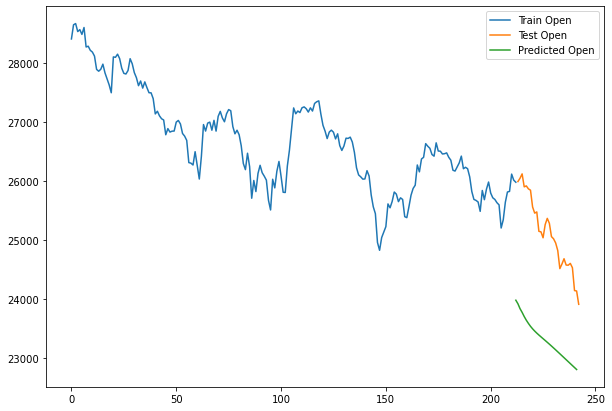

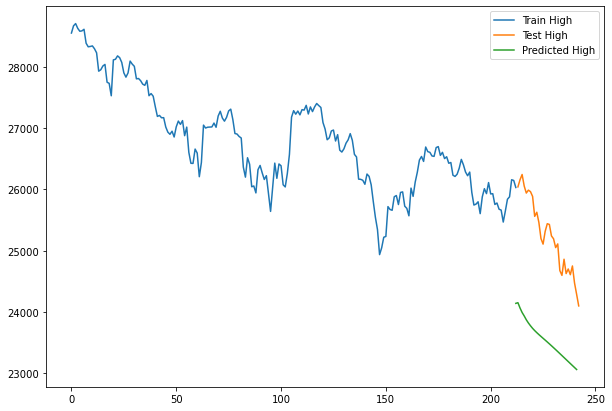

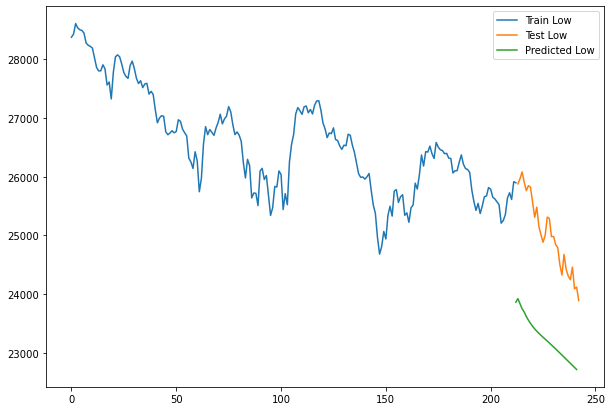

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in ['Open', 'High', 'Low']:
    
    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot( train[str(i)], label='Train '+str(i))
    plt.plot(test[str(i)], label='Test '+str(i))
    plt.plot(res[str(i)+'_1st_inv_diff'], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()